In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os, pickle
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.ndimage import gaussian_filter
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

from src.model import intensity, create_connect_mat
from src.sim import sim_lif_perturbation, sim_determ_lif_recep, sim_determ_lif_recep_simp, sim_stoch_lif_recep

In [3]:
from scripts.prob_decision import *

### Cell Type Params

In [ ]:
connect_prob_huang = np.array([[0.01, 0.04, 0.03, 0],
                               [0.03, 0.04, 0.03, 0],
                               [0.03, 0, 0, 0.1],
                               [0.01, 0, 0.1, 0]])

# connect_strengths_huang = np.array([[30, 90, 120, 0],
#                                     [40, 150, 60, 0],
#                                     [27, 0, 0, 10],
#                                     [72, 0, 10, 0]])

post_syn_connect_huang = np.array([[400, 1600, 1200, 0],
                                   [120, 160, 120, 0],
                                   [120, 0, 0, 400],
                                   [20, 0, 200, 0]])
connect_prob_2 = post_syn_connect_huang / post_syn_connect_huang.sum()

# N_huang = np.array([[40, 4, 4, 2]]).T

In [ ]:
tcp = connect_prob_2.copy()
#tcp[0,0] = 0.2 # altering?
tcp 

In [ ]:
tcp = np.array([[1, 1, 1, 0],
                [1, 1, 1, 0],
                [1, 0, 0, 1],
                [1, 0, 1, 0]])

In [ ]:
Npyr = 3200
Npv = 320
Nsst = 320
Nvip = 160

pyr_idx = Npyr
pv_idx = pyr_idx + 320
sst_idx = pv_idx + 320
vip_idx = sst_idx + 160


ct_n = [Npyr, Npv, Nsst, Nvip]
ct_idx = [0, pyr_idx, pv_idx, sst_idx, vip_idx]
ct_names = ["Pyramidal", "PV+", "SST+", "VIP"]

In [ ]:
# afferent indices
pvn = 1
sstn = 2
vipn = 3

print(f"Number of inhibitory postsynaptic connections to PV+: {tcp[pvn,1:] @ ct_n[1:]}")
print(f"Number of inhibitory postsynaptic connections to SST+: {tcp[sstn,1:] @ ct_n[1:]}")
print(f"Number of inhibitory postsynaptic connections to VIP: {tcp[vipn,1:] @ ct_n[1:]}")

In [ ]:
# from Pfeffer et al. 2013
mut_inh = np.array([[1, 1, 0.54, 0],
                    [1, 1, 0.33, 0],
                    [1, 0, 0, 0.15],
                    [1, 0.22, 0.77, 0]])
#mut_inh[2,3] = 1.8

con_str = tcp * mut_inh
print(f"Postsynaptic inhibitory connection strength to PV+: {con_str[pvn,1:] @ ct_n[1:]}")
print(f"Postsynaptic inhibitory connection strength to SST+: {con_str[sstn,1:] @ ct_n[1:]}")
print(f"Postsynaptic inhibitory connection strength to VIP: {con_str[vipn,1:] @ ct_n[1:]}")

In [ ]:
connect_mat = np.zeros((4000,4000))

for pre in range(1,5): # presynaptic
    for pos in range(1,5): # postsynaptic
        connect_mat[ct_idx[pos-1]:ct_idx[pos], ct_idx[pre-1]:ct_idx[pre]] = np.random.binomial(n=1,
                                                                                               p=tcp[pos-1,pre-1],
                                                                                               size=(ct_n[pos-1],ct_n[pre-1])) #* mut_inh[pos-1,pre-1]

## Simulations

### Original

A mean rate: 40.0 Hz
B mean rate: 40.0 Hz
Stimulation length: 2 seconds
Simulating network of 2000 neurons


  0%|          | 0/199998 [00:00<?, ?it/s]

Reaction time: 0.7682619647355162 seconds


ValueError: x and y must have same first dimension, but have shapes (200000,) and (199999,)

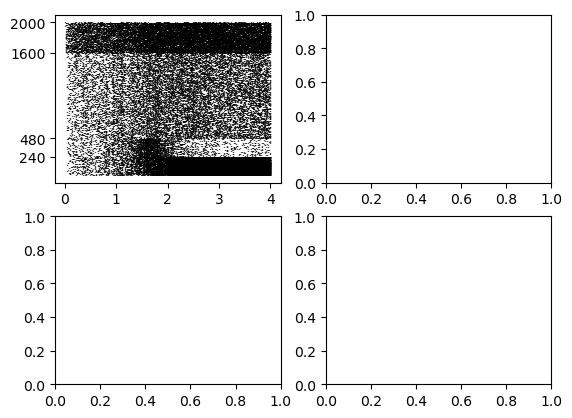

In [4]:
lif_simO,sens_inputO,firing_ratesO,reaction_timeO = produce_prob_decision(mu_0=40, coh=0, stim_len=2)

In [12]:
print("lifsimog")
print("Total", np.trapezoid(-lif_simO['syn_currents']['total'][:10000,0]))
print("extAMPA", np.trapezoid(-lif_simO['syn_currents']['ext_ampa'][:10000,0]))
print("AMPA", np.trapezoid(-lif_simO['syn_currents']['ampa'][:10000,0]))
print("NMDA", np.trapezoid(-lif_simO['syn_currents']['nmda'][:10000,0]))
print("GABA", np.trapezoid(-lif_simO['syn_currents']['gaba'][:10000,0]))

lifsimog
Total 4355290.118184134
extAMPA 5473310.459213827
AMPA 154966.82478427904
NMDA 1574209.7745130018
GABA -2847196.9403269724


### stoch

A mean rate: 40.0 Hz
B mean rate: 40.0 Hz
Stimulation length: 2 seconds
Simulating network of 2000 neurons


  0%|          | 0/39999 [00:00<?, ?it/s]

Reaction time: 0.436156763590392 seconds


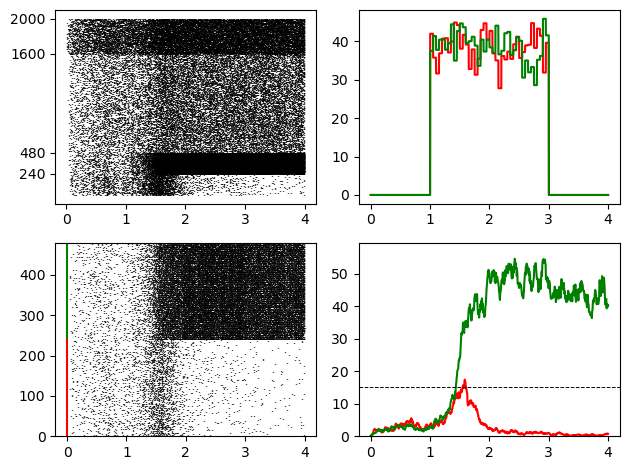

In [12]:
lif_simS,sens_inputS,firing_ratesS,reaction_timeS = produce_prob_decision(mu_0=40, coh=0, stim_len=2, sim_func=sim_stoch_lif_recep)

In [ ]:
print("lifstimorig")
print("Total", np.trapezoid(-lif_simO['syn_currents']['total'][:10000,0]))
print("extAMPA", np.trapezoid(-lif_simO['syn_currents']['ext_ampa'][:10000,0]))
print("AMPA", np.trapezoid(-lif_simO['syn_currents']['ampa'][:10000,0]))
print("NMDA", np.trapezoid(-lif_simO['syn_currents']['nmda'][:10000,0]))
print("GABA", np.trapezoid(-lif_simO['syn_currents']['gaba'][:10000,0]))

In [ ]:
print("lifsimstoch")
print("Total", np.trapezoid(-lif_simS['syn_currents']['total'][:10000,0]))
print("extAMPA", np.trapezoid(-lif_simS['syn_currents']['ext_ampa'][:10000,0]))
print("AMPA", np.trapezoid(-lif_simS['syn_currents']['ampa'][:10000,0]))
print("NMDA", np.trapezoid(-lif_simS['syn_currents']['nmda'][:10000,0]))
print("GABA", np.trapezoid(-lif_simS['syn_currents']['gaba'][:10000,0]))

lifsimstoch
Total 5990503.716017727
extAMPA 4710239.8767917
AMPA 239039.37040539872
NMDA 3110336.8611794515
GABA -2069112.3923588237


### Reduced N

In [ ]:
lif_sim,sens_input,firing_rates,reaction_time = produce_prob_decision(mu_0=40, coh=51.2, stim_len=2, Ne=200, Ni=50)

In [ ]:
print("lifsim")
print("Total", np.trapezoid(-lif_sim['syn_currents']['total'][:10000,0]))
print("extAMPA", np.trapezoid(-lif_sim['syn_currents']['ext_ampa'][:10000,0]))
print("AMPA", np.trapezoid(-lif_sim['syn_currents']['ampa'][:10000,0]))
print("NMDA", np.trapezoid(-lif_sim['syn_currents']['nmda'][:10000,0]))
print("GABA", np.trapezoid(-lif_sim['syn_currents']['gaba'][:10000,0]))

### Simplified currents

In [ ]:
lif_simS,sens_inputS,firing_ratesS,reaction_timeS = produce_prob_decision(mu_0=40, coh=51.2, stim_len=2, sim_func=sim_determ_lif_recep_simp)

In [ ]:
def testmg(vt):
    Ve = 0
    return (-(0.165 * (vt - Ve)) / (1 + (np.exp(-0.062 * vt) / 3.57)))

def regsimp(vt, b1, b0):
    return b1 * vt + b0

In [ ]:
print("lifsim")
print("Total", np.trapezoid(-lif_sim['syn_currents']['total'][:10000,0]))
print("extAMPA", np.trapezoid(-lif_sim['syn_currents']['ext_ampa'][:10000,0]))
print("AMPA", np.trapezoid(-lif_sim['syn_currents']['ampa'][:10000,0]))
print("NMDA", np.trapezoid(-lif_sim['syn_currents']['nmda'][:10000,0]))
print("GABA", np.trapezoid(-lif_sim['syn_currents']['gaba'][:10000,0]))

In [ ]:
print("simp")
print("Total", np.trapezoid(lif_simS['syn_currents']['total'][:10000,0]))
print("extAMPA", np.trapezoid(lif_simS['syn_currents']['ext_ampa'][:10000,0]))
print("NMDA", np.trapezoid(lif_simS['syn_currents']['nmda'][:10000,0]))
print("GABA", np.trapezoid(lif_simS['syn_currents']['gaba'][:10000,0]))

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(-lif_sim['syn_currents']['ext_ampa'][:,0], label='OG')
ax[0].set_xlabel("OG")
ax[0].set_ylim((0, 1300))
ax[1].plot(lif_simS['syn_currents']['ext_ampa'][:,0], label='simp')
ax[1].set_xlabel("simplified")
ax[1].set_ylim((0, 1300))
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(-lif_sim['syn_currents']['nmda'][:10000,0], label='OG')
ax[0].set_xlabel("OG")
ax[1].plot(lif_simS['syn_currents']['nmda'][:10000,0], label='simp')
ax[1].set_xlabel("simplified")
fig.tight_layout()

In [ ]:
plt.plot(-lif_sim['syn_currents']['nmda'][2000:10000,0])

In [ ]:
plt.plot(lif_simS['syn_currents']['nmda'][2000:10000,0])